# Analogue Field Test 1 Data Analysis

Krystal Arroyo-Flores  
10/19/2023

#### *Code Imports*

In [1]:
%matplotlib widget

# Our standard imports:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import cm
import seaborn as sn
from pandas.testing import assert_frame_equal

# Access to many standard distributions:
import scipy.stats as ss
import pandas as pd
import re
import csv
import xarray as xr
import math as mth

### **START**
Already shortened: *df_fielddata*, *df_refdata*, *df_all*, *corrMx*

In [3]:
## Step 1
# selections = ['specfiles_org_ascend2023_field.csv','specfiles_org_ascend2023_lib.csv'] # ordered, labels in 2nd column, field by spot
selections = ['specfiles_org_ascend2023_field2.csv','specfiles_org_ascend2023_lib.csv'] # field w/ AM & PM groups

filenameslist = []
labelnameslist = []
for s in selections:
    names = []
    names = pd.read_csv(s)
    filenames = names.FileName.tolist()
    labelnames = names.LabelName.tolist()
    for count, fn in enumerate(filenames):
        if '\n' in fn:
            fn = fn.split('\n')[1]
            filenames[count] = fn
    filenameslist.append(filenames)
    labelnameslist.append(labelnames)
    
print(filenameslist)
print(len(filenameslist[0]),len(filenameslist[1])) # 68 field, 27 lib
print(labelnameslist)
print(len(labelnameslist[0]),len(labelnameslist[1])) # 68 field, 27 lib


[['friamwr_avg.md', 'friam_basaltspot1_median.md', 'friam_spot2lyr_top_avg.md', 'friam_spot2lyr_middlelight_avg.md', 'friam_spot2lyr_thirddark_avg.md', 'friam_spot4_xenopyx_avg_2-7.md', 'satam_sp2_med.md', 'satam_sp3_med.md', 'satam_sp4_med.md', 'satam_sp5_med.md', 'satam_sp6_med.md', 'satam_sp7_med.md', 'satam_sp8_med.md', 'satam_sp9_med.md', 'satam_sp10_med.md', 'satam_sp11_med.md', 'satam_sp12_med.md', 'fripm_spcenter_med.md', 'fripm_sp2_med.md', 'fripm_sp3_med.md', 'fripm_sp4_med.md', 'fripm_sp5_med.md', 'fripm_sp6_med.md', 'fripm_sp7_med.md', 'fripm_sp8_med.md', 'fripm_sp9_med.md', 'fripm_sp10_median.md', 'fripm_sp11N_med.md', 'fripm_sp12_med.md', 'satam_sp13_med.md', 'satam_sp14_med.md', 'satam_sp15_med.md', 'satam_sp16_med.md', 'satam_sp17_med.md', 'satam_sp18_med.md', 'satam_sp19_med.md', 'satam_sp20_med.md', 'satam_sp21_med.md', 'satam_sp22_med.md', 'satam_sp23_med.md', 'satam_sp24_med.md', 'satpm_1twobigrks_med.md', 'satpm_20_med.md', 'satpm_3bigrock_med.md', 'satpm_3bigrock_

In [4]:
## Step 2
directory = ['averagedfilenames_field.csv','averagedfilenames_lib.csv'] # where the actual data files are

datafiles = []
for d in directory:
    names = []
    names = pd.read_csv(d)
    names = names.Name.tolist()
    datafiles.append(names)
# print(datafiles)

df_fielddata = pd.DataFrame()
df_wavelengths = pd.DataFrame()
df_refdata = pd.DataFrame()

for count, filelist in enumerate(datafiles): # 2 lists, one from field csv, one from lib csv (all file names in data folders)
    if count>0: # finished iterating through field files
        ## create empty dataframe w/ our wavelength range as index, taken from field data df [350:2500]
        w = pd.DataFrame({'Wavelength':df_wavelengths[df_wavelengths.columns[0]].values}, dtype=float)
        w = w.set_index('Wavelength')
        df_refdata = df_refdata.reindex(w.index)
        df_fielddata = df_fielddata.set_index(w.index)
        # print('Wavelength section: \n',df_refdata,'\n',df_fielddata)
    
    for idx, val in np.ndenumerate(filenameslist[0]): # go through field selection order
        for fn in filelist: # fn is the full txt file name, filenameslist has the xxxx.md version
            
            if val in fn:
                i=idx[0]
                label = labelnameslist[0][i]
                path = 'Krystal_ASD_Data/MK_Averaged/' + fn
                specdata = []
                specdata = pd.read_csv(path,delimiter="\t",header=39, index_col=0)
                df_fielddata[label] = specdata[specdata.columns[0]]   # if set index, use col[0] instead of [1]
                df_wavelengths[label] = specdata.index # if set index, use .index to get instead of [specdata.columns[0]], uses shortened file name
                # print('Field section: \n',df_fielddata,'\n',df_wavelengths,'\n\n')
                
    for idx, val in np.ndenumerate(filenameslist[1]): # go through library selection order
        for fn in filelist: # fn is the full tab file name, filenameslist has the xxxx(no .tab) version
            if val in fn:
                i=idx[0]
                label = labelnameslist[1][i]
                path = 'Spectral_Library_Files/' + fn
                refdata = []
                with open(path, 'r') as file:   # get length of data for specific file - consulted chatgpt for syntax
                    length = int(file.readline().strip())
                    ## correct length, only the numbers (as floats), only Wavelength (as index) & Reflectance (named w/ shortened file name)
                    refdata = pd.read_csv(path, skiprows=1, nrows=length, sep="\s+", header=None, dtype=float, names=['Wavelength',label,'StdDev'], index_col=0)
                    dataset_ref = refdata.iloc[0:,0:1]
                    result = w.join(dataset_ref) # map current file data to standard Wavelength range (adds NaNs)
                    df_refdata = pd.concat([df_refdata,result[result.columns[0]]],axis=1)
                    # print('Library section: \n',result,'\n',df_refdata,'\n\n')
            
# print('Field data: ',len(df_fielddata),'\n\n',df_fielddata,'\n\n')
# print('Library data: ',len(df_refdata),'\n\n',df_refdata)
df_fielddata.info() # *** only 65 cols, 3 files got dropped, fix*******
df_refdata.info()
# df_refdata.dtypes  # checks data types
# df_refdata.count() # gives non-null totals


<class 'pandas.core.frame.DataFrame'>
Float64Index: 2151 entries, 350.0 to 2500.0
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 2151 non-null   float64
 1   PS 01 Basalt             2151 non-null   float64
 2   PS 02 Top Soil           2151 non-null   float64
 3   PS 02 Mid, Light         2151 non-null   float64
 4   PS 02 Bottom, Dark       2151 non-null   float64
 5   PS 04 PyroxRock          2151 non-null   float64
 6   Spiral 02_AM             2151 non-null   float64
 7   Spiral 03_AM             2151 non-null   float64
 8   Spiral 04_AM             2151 non-null   float64
 9   Spiral 05_AM             2151 non-null   float64
 10  Spiral 06_AM             2151 non-null   float64
 11  Spiral 07_AM             2151 non-null   float64
 12  Spiral 08_AM             2151 non-null   float64
 13  Spiral 09_AM             2151 non-null   float64
 14  Spiral 10_AM    

In [5]:
## Step 3

## create correlation matrix - FIELD vs LIBRARY - All(both)
df_all = pd.concat([df_fielddata,df_refdata],axis=1)
corrMx = df_all.corr() #.corr(method='pearson')#,'kendall','spearman')
print('All data: ',len(df_all),'\n\n',df_all,'\n\n')
print('Correlation Matrix: ',len(corrMx),'\n\n',corrMx)
df_all.info()
corrMx.info()

All data:  2151 

             PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Wavelength                                                             
350.0       0.016146      0.018525        0.016985          0.021962   
351.0       0.016002      0.018455        0.017070          0.022015   
352.0       0.015951      0.018537        0.016873          0.022002   
353.0       0.016247      0.018499        0.016856          0.022066   
354.0       0.016270      0.018533        0.016990          0.022107   
...              ...           ...             ...               ...   
2496.0      0.000029      0.106448        0.048960          0.105140   
2497.0      0.005046      0.112110        0.048714          0.104610   
2498.0      0.035094      0.109559        0.048528          0.105506   
2499.0      0.041443      0.105511        0.050883          0.104564   
2500.0      0.052210      0.072024        0.059441          0.099409   

            PS 02 Bottom, Dark  PS 04 PyroxR

# Remove Noise from Analog Data and Plot Before and After
Shortened: *df_chop*

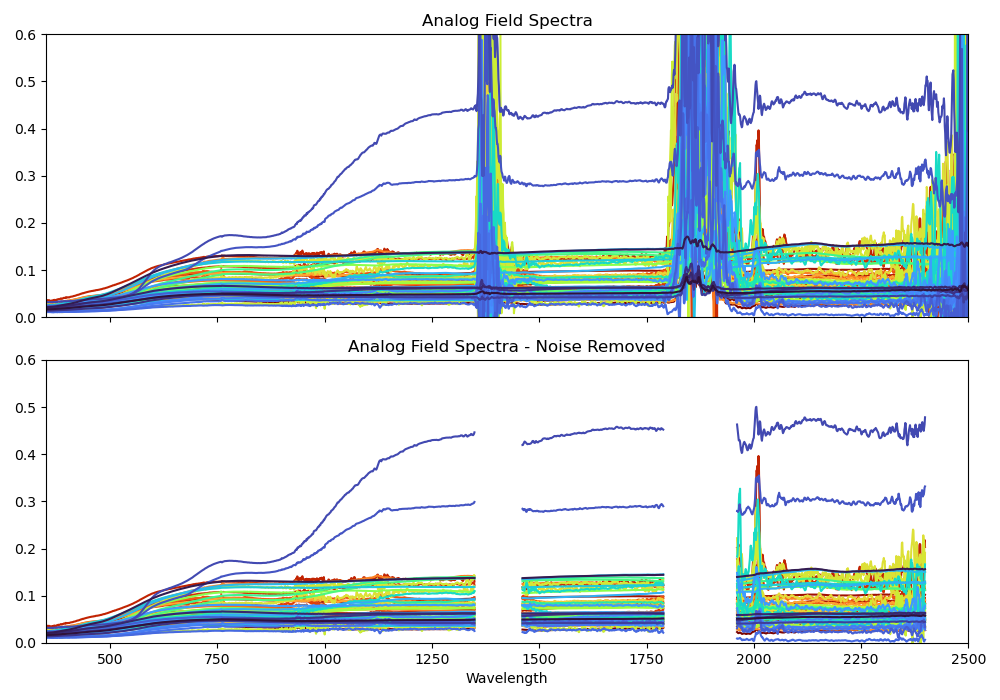

In [6]:
## Step 4

## Field Data Plot (df_fielddata)
plt.close('all')
f_field, (ax_field, ax_chop) = plt.subplots(2, sharex=True, sharey=True) # creates matplotlib figure - 2 vertically stacked subplots, share x-axis & y-axis scale

df_fielddata.plot(figsize=(10,7),ax=ax_field,legend=False,colormap='turbo_r') # (width, height) in inches
ax_field.set_title('Analog Field Spectra')


## create new dataframe with noisy bands changed to NaNs
w_noise = [[1350,1460],[1790,1960],[2400,2500]]

df_chop = df_fielddata.copy()
for band, vals in enumerate(w_noise):
    df_chop.loc[vals[0]:vals[1]]=np.nan


## plot the dataframe after - Field Data Plot (df_chop)
df_chop.plot(ax=ax_chop,legend=False,colormap='turbo_r') # (width, height) in inches
ax_chop.set_title('Analog Field Spectra - Noise Removed')

plt.ylim(0,0.6)
plt.xlim(350,2500)
f_field.tight_layout(pad=1) # handles margins
plt.show()

# Save plot to file
f_field.savefig('analogSpectra_Noise.pdf')

In [7]:
## Step 5
df_chop.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2151 entries, 350.0 to 2500.0
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 1768 non-null   float64
 1   PS 01 Basalt             1768 non-null   float64
 2   PS 02 Top Soil           1768 non-null   float64
 3   PS 02 Mid, Light         1768 non-null   float64
 4   PS 02 Bottom, Dark       1768 non-null   float64
 5   PS 04 PyroxRock          1768 non-null   float64
 6   Spiral 02_AM             1768 non-null   float64
 7   Spiral 03_AM             1768 non-null   float64
 8   Spiral 04_AM             1768 non-null   float64
 9   Spiral 05_AM             1768 non-null   float64
 10  Spiral 06_AM             1768 non-null   float64
 11  Spiral 07_AM             1768 non-null   float64
 12  Spiral 08_AM             1768 non-null   float64
 13  Spiral 09_AM             1768 non-null   float64
 14  Spiral 10_AM    

# Analog Correlation Matrix, No Noise

### Create Analog Correlation Matrix from DataFrame w/ NaN-Replaced Noise Bands, Shorten File Names, Check Equality
Shortened: *corrMx_analog*

In [8]:
## Step 6
corrMx_analog = df_chop.corr() #.corr(method='pearson')#,'kendall','spearman')
corrMx_analog.info() # shortened

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, PS Setup to Slope 18 TopMxdGravel
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 65 non-null     float64
 1   PS 01 Basalt             65 non-null     float64
 2   PS 02 Top Soil           65 non-null     float64
 3   PS 02 Mid, Light         65 non-null     float64
 4   PS 02 Bottom, Dark       65 non-null     float64
 5   PS 04 PyroxRock          65 non-null     float64
 6   Spiral 02_AM             65 non-null     float64
 7   Spiral 03_AM             65 non-null     float64
 8   Spiral 04_AM             65 non-null     float64
 9   Spiral 05_AM             65 non-null     float64
 10  Spiral 06_AM             65 non-null     float64
 11  Spiral 07_AM             65 non-null     float64
 12  Spiral 08_AM             65 non-null     float64
 13  Spiral 09_AM             65 non-null     float64
 14  Spiral 

### Create Analog DataFrame w/ Dropped Noise Bands, Create Correlation Matrix
Shortened: *df_drop*, *corrMx_analog2*

In [9]:
## Step 7
## drop bands
w_noise = [[1350,1460],[1790,1960],[2400,2500]]
df_drop = df_fielddata.copy()

for band, vals in enumerate(w_noise):
    df_drop = df_drop.drop(df_drop.loc[vals[0]:vals[1]].index)
# with pd.option_context('display.max_rows', None):
#     print(df_drop,'\n')
# df_drop.info()

## make new corr matrix - No Noise (df_drop - NO NaNs)
corrMx_analog2 = df_drop.corr() #.corr(method='pearson')#,'kendall','spearman')
df_drop.info()
corrMx_analog2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1768 entries, 350.0 to 2399.0
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 1768 non-null   float64
 1   PS 01 Basalt             1768 non-null   float64
 2   PS 02 Top Soil           1768 non-null   float64
 3   PS 02 Mid, Light         1768 non-null   float64
 4   PS 02 Bottom, Dark       1768 non-null   float64
 5   PS 04 PyroxRock          1768 non-null   float64
 6   Spiral 02_AM             1768 non-null   float64
 7   Spiral 03_AM             1768 non-null   float64
 8   Spiral 04_AM             1768 non-null   float64
 9   Spiral 05_AM             1768 non-null   float64
 10  Spiral 06_AM             1768 non-null   float64
 11  Spiral 07_AM             1768 non-null   float64
 12  Spiral 08_AM             1768 non-null   float64
 13  Spiral 09_AM             1768 non-null   float64
 14  Spiral 10_AM    

## No-Noise Analog Heatmap (created using drop DataFrame)

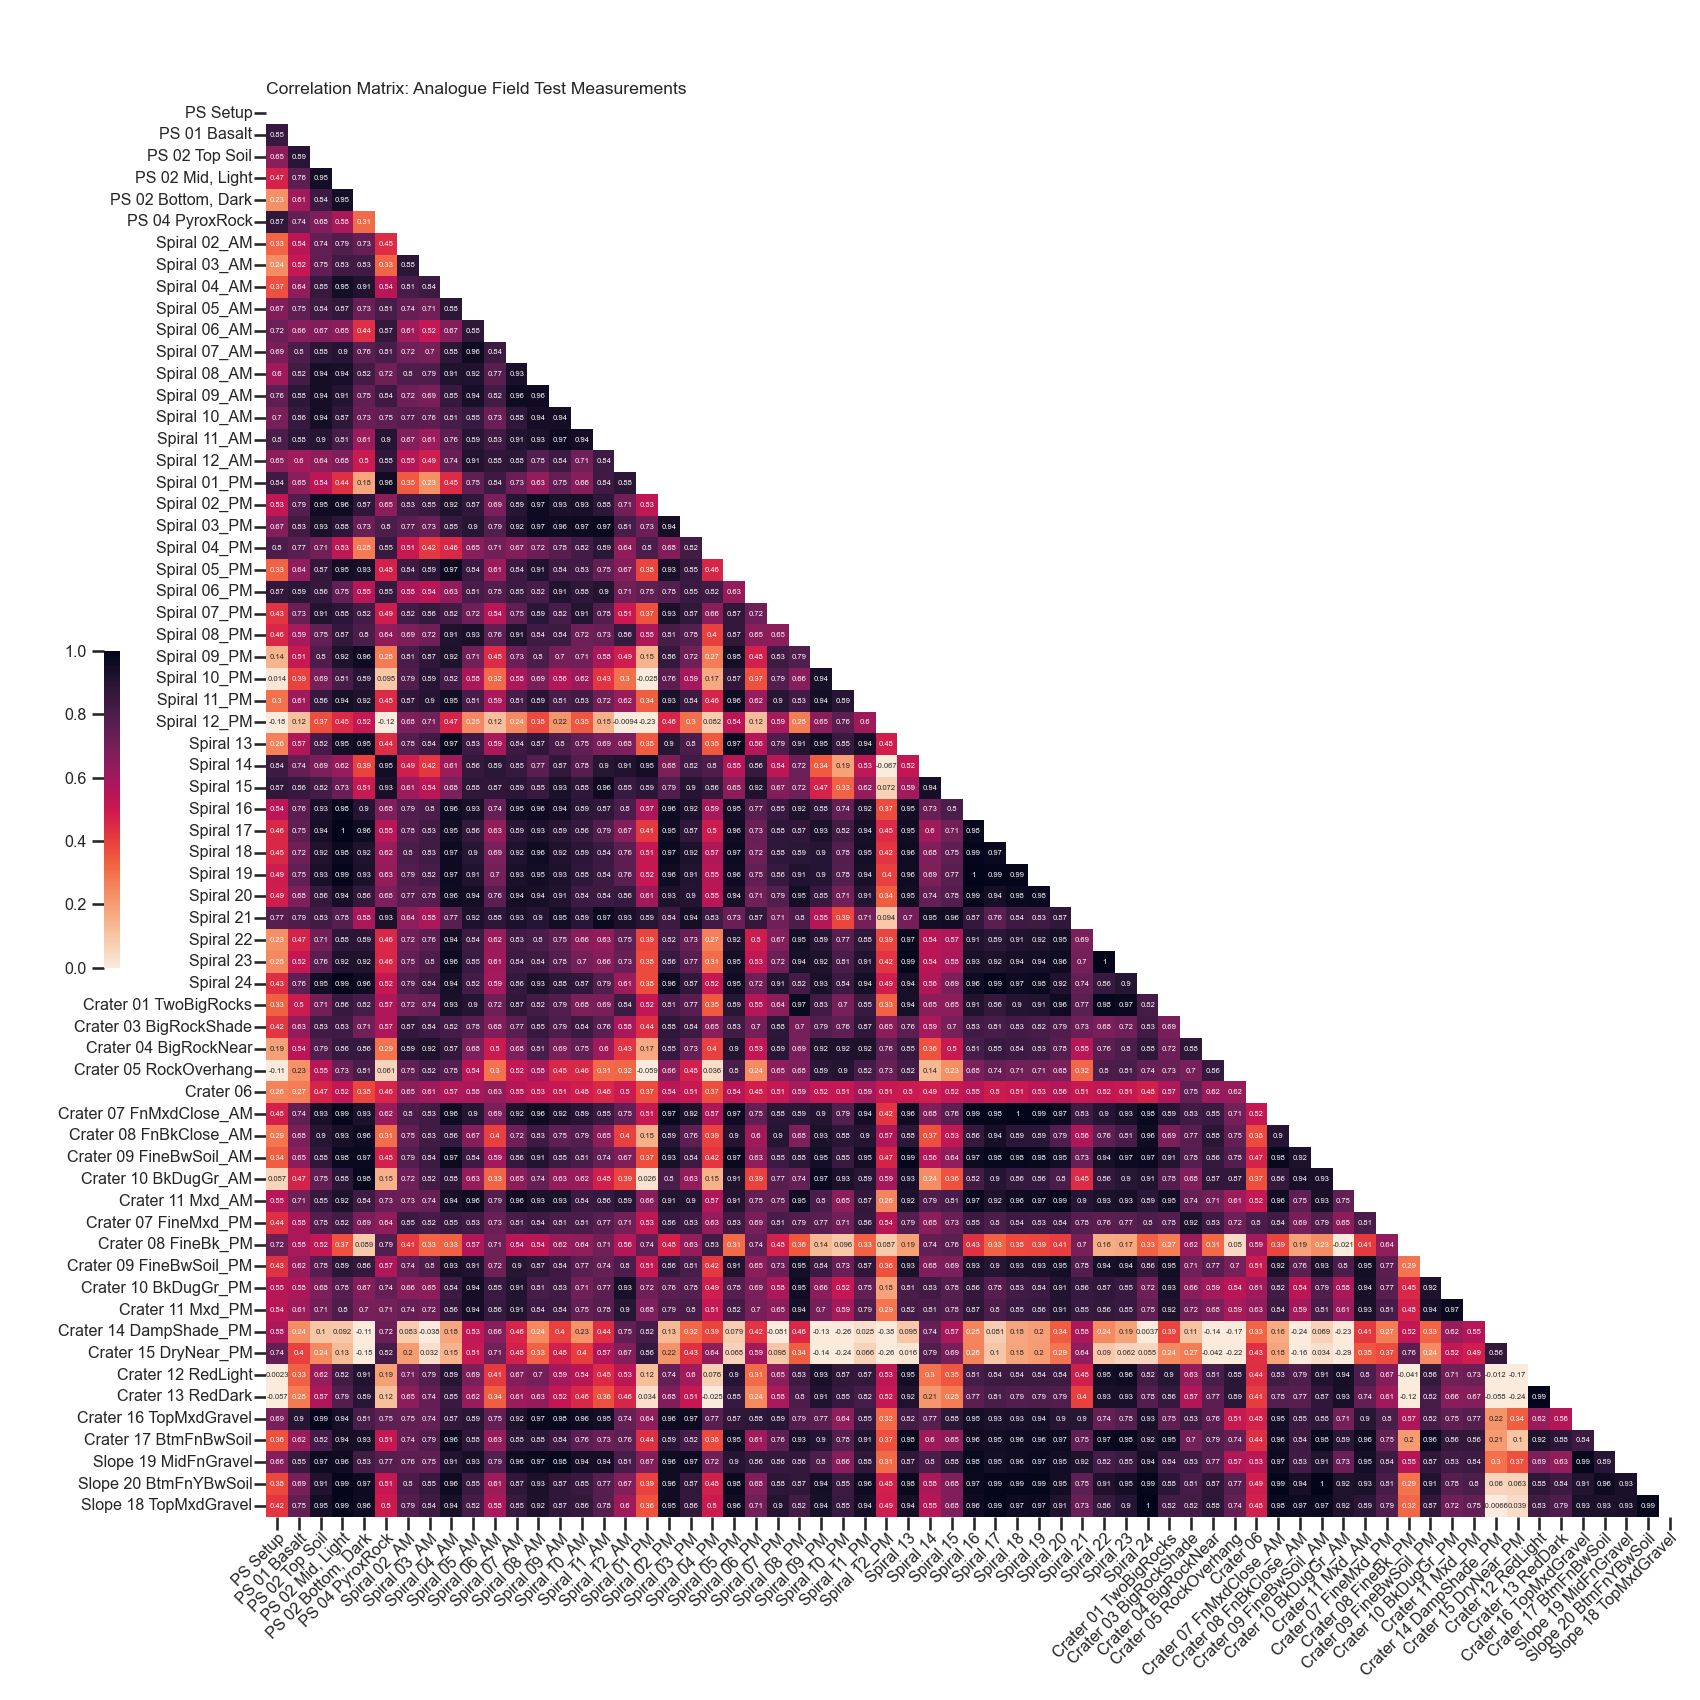

                        PS Setup  PS 01 Basalt  PS 02 Top Soil  \
PS Setup                1.000000      0.854588        0.647521   
PS 01 Basalt            0.854588      1.000000        0.892147   
PS 02 Top Soil          0.647521      0.892147        1.000000   
PS 02 Mid, Light        0.470277      0.758272        0.951614   
PS 02 Bottom, Dark      0.233793      0.606370        0.840696   
...                          ...           ...             ...   
Crater 16 TopMxdGravel  0.691146      0.895261        0.986341   
Crater 17 BtmFnBwSoil   0.361501      0.624647        0.819407   
Slope 19 MidFnGravel    0.662150      0.848952        0.966302   
Slope 20 BtmFnYBwSoil   0.380329      0.693481        0.913883   
Slope 18 TopMxdGravel   0.420880      0.747538        0.947762   

                        PS 02 Mid, Light  PS 02 Bottom, Dark  PS 04 PyroxRock  \
PS Setup                        0.470277            0.233793         0.869857   
PS 01 Basalt                    0.758272     

In [10]:
## Step 8

## Correlation Matrix Plot - field only, all spots, lower half, shorter names, NO NOISE **with pre-shortened names in (corrMx_analog2)**
plt.close('all')

sn.set_theme(style='white')
# sn.set_context('paper', font_scale=1.0) # paper,notebook,talk,poster
sn.set_context('talk', font_scale=0.7)
mask_analog = np.triu(np.ones_like(corrMx_analog2, dtype=bool),0) # Generate a mask for the upper triangle (where those cells = True)
f_analog, ax_analog = plt.subplots(figsize=(17,17)) # creates matplotlib figure
ax_analog = sn.heatmap(corrMx_analog2, vmin=0, vmax=1, square=True, 
                       annot=True, annot_kws={'size':5.5}, cmap='rocket_r', mask=mask_analog, 
                       # cbar_kws={'fraction':0.04,'shrink':0.25,'pad':0.05})
                       cbar_kws={'location':'left','fraction':0.04,'shrink':0.2,'pad':0.09}) 
# annotated w/ coeffs, masks upper triangle, sets color floor at 0, keeps cells square, shrinks colorbar

title = 'Correlation Matrix: Analogue Field Test Measurements'
# ax_analog.set_title(title)
ax_analog.set_title(title,loc='left') # align title to left
ax_analog.tick_params(axis='both',pad=1)#,labelsize=7)
ax_analog.tick_params(left=True,top=False, bottom=True,labeltop=False, labelbottom=True)
plt.setp(ax_analog.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.
f_analog.tight_layout(pad=1) # handles margins
plt.show()

## Save plot to file
f_analog.savefig('analogMx_NoNoise_Ltri.pdf')
## Save plot to file - PNG
# f_analog.savefig('analogMx_NoNoise_Ltri.png')

print(corrMx_analog2)

# Library Files

## Create NaN-replaced and Dropped Noise Library DataFrames and Compare non-Null Counts
**Start Here** after already have *df_refdata*

In [11]:
## Step 9

## view Noise wavelengths in lib files (df_refdata)
w_noise = [[1350,1460],[1790,1960],[2400,2500]]

# for band, vals in enumerate(w_noise):
#     with pd.option_context('display.max_rows', None,'display.max_columns', None):
#         print(df_refdata.loc[vals[0]:vals[1]]))
        
df_refdata.info()
# with pd.option_context('display.max_rows', None,'display.max_columns', None):
#     print(df_refdata.count()) # gives non-null totals
ref_count_before = df_refdata.count().values # gives non-null totals # original count: [41,...,431]
print(ref_count_before)
print('min count: ',np.min(ref_count_before),' max count: ',np.max(ref_count_before))


## Try: replace with NaNs
df_ref_nan = df_refdata.copy()
for band, vals in enumerate(w_noise):
    df_ref_nan.loc[vals[0]:vals[1]]=np.nan

df_ref_nan.info()
# with pd.option_context('display.max_rows', None,'display.max_columns', None):
#     print(df_ref_nan.count()) # gives non-null totals
ref_count_nans = df_ref_nan.count().values # gives non-null totals # original count: [41,...,431]
print(ref_count_nans)
print('min count: ',np.min(ref_count_nans),' max count: ',np.max(ref_count_nans)) # NaN replace count: [31,...,356]


## Try: drop rows
df_ref_drop = df_refdata.copy()
for band, vals in enumerate(w_noise):
    df_ref_drop = df_ref_drop.drop(df_ref_drop.loc[vals[0]:vals[1]].index)

df_ref_drop.info()
# with pd.option_context('display.max_rows', None,'display.max_columns', None):
#     print(df_ref_drop.count()) # gives non-null totals
ref_count_drop = df_ref_drop.count().values # gives non-null totals # original count: [41,...,431]
print(ref_count_drop)
print('min count: ',np.min(ref_count_drop),' max count: ',np.max(ref_count_drop)) # NaN replace count: [31,...,356]

np.array_equal(ref_count_nans,ref_count_drop) # same non-Null count w/ NaNs or drop

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2151 entries, 350.0 to 2500.0
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sim5 H 0-106u       431 non-null    float64
 1   Sim4 H 106-180u     431 non-null    float64
 2   Sim3 H 180-750u     431 non-null    float64
 3   Sim1 H 0-1000u      431 non-null    float64
 4   Sim12 M 106-180u    431 non-null    float64
 5   Sim11 M 180-750u    431 non-null    float64
 6   Sim10 M 0-1000u     431 non-null    float64
 7   Sim30 Ba 0-1000u    431 non-null    float64
 8   Sim26 Ba 0-500u     431 non-null    float64
 9   Sim31 An 0-1000u    431 non-null    float64
 10  Sim17 An 0-2000u    431 non-null    float64
 11  Ap16 H 0-10u        431 non-null    float64
 12  Ap16 H 0-20u        431 non-null    float64
 13  Ap16 H 10-20u       431 non-null    float64
 14  Ap16 H 20-45u       431 non-null    float64
 15  Ap16 H 45-90u       431 non-null    float64
 16

True

In [12]:
## Step 10
df_refdata
df_ref_nan
df_ref_drop
# with pd.option_context('display.max_rows', None):
    # print(df_refdata)
    # print(df_ref_nan)
    # print(df_ref_drop)

Sim5 H 0-106u  Sim4 H 106-180u  Sim3 H 180-750u  Sim1 H 0-1000u  \
Wavelength                                                                    
350.0             0.27064          0.11256          0.06353         0.07888   
351.0                 NaN              NaN              NaN             NaN   
352.0                 NaN              NaN              NaN             NaN   
353.0                 NaN              NaN              NaN             NaN   
354.0                 NaN              NaN              NaN             NaN   
...                   ...              ...              ...             ...   
2395.0            0.38003          0.17869          0.10198         0.25872   
2396.0                NaN              NaN              NaN             NaN   
2397.0                NaN              NaN              NaN             NaN   
2398.0                NaN              NaN              NaN             NaN   
2399.0                NaN              NaN              NaN             NaN   

            Sim12 M 106-180u  Sim11 M 180-750u  Sim10 M 0-1000u  \
Wavelength                                                        
350.0                0.03771           0.03603          0.03965   
351.0                    NaN               NaN              NaN   
352.0                    NaN               NaN              NaN   
353.0                    NaN               NaN              NaN   
354.0                    NaN               NaN              NaN   
...                      ...               ...              ...   
2395.0               0.10823           0.04849          0.15354   
2396.0                   NaN               NaN              NaN   
2397.0                   NaN               NaN              NaN   
2398.0                   NaN               NaN              NaN   
2399.0                   NaN               NaN              NaN   

            Sim30 Ba 0-1000u  Sim26 Ba 0-500u  Sim31 An 0-1000u  ...  \
Wavelength                                                       ...   
350.0                0.03942          0.03561           0.19808  ...   
351.0                    NaN              NaN               NaN  ...   
352.0                    NaN              NaN               NaN  ...   
353.0                    NaN              NaN               NaN  ...   
354.0                    NaN              NaN               NaN  ...   
...                      ...              ...               ...  ...   
2395.0               0.14052          0.17962           0.38203  ...   
2396.0                   NaN              NaN               NaN  ...   
2397.0                   NaN              NaN               NaN  ...   
2398.0                   NaN              NaN               NaN  ...   
2399.0                   NaN              NaN               NaN  ...   

            Ap16 H 250-500u  Ap16 H 500-1000u  Ap14 H SurfaceSoil  Ap17 Soil  \
Wavelength                                                                     
350.0               0.13653           0.11460             0.04314        NaN   
351.0                   NaN               NaN                 NaN        NaN   
352.0                   NaN               NaN                 NaN        NaN   
353.0                   NaN               NaN                 NaN        NaN   
354.0                   NaN               NaN                 NaN        NaN   
...                     ...               ...                 ...        ...   
2395.0              0.22479           0.20181             0.24333        NaN   
2396.0                  NaN               NaN                 NaN        NaN   
2397.0                  NaN               NaN                 NaN        NaN   
2398.0                  NaN               NaN                 NaN        NaN   
2399.0                  NaN               NaN                 NaN        NaN   

            Ap15 Basalt  Ap11 M 0-45u  Ap11 M 45-75u  Ap11 M 75-125u  \
Wavelength                                                    

## Create correlation matrix - Library files ONLY

In [13]:
## Step 11

libcorr_drop = df_ref_drop.corr()
libcorr_drop

Sim5 H 0-106u  Sim4 H 106-180u  Sim3 H 180-750u  \
Sim5 H 0-106u            1.000000         0.977421         0.973445   
Sim4 H 106-180u          0.977421         1.000000         0.997458   
Sim3 H 180-750u          0.973445         0.997458         1.000000   
Sim1 H 0-1000u           0.762714         0.628296         0.630300   
Sim12 M 106-180u         0.913471         0.868607         0.857232   
Sim11 M 180-750u         0.689137         0.772935         0.756839   
Sim10 M 0-1000u          0.750862         0.613956         0.605352   
Sim30 Ba 0-1000u         0.744897         0.607437         0.598680   
Sim26 Ba 0-500u          0.761278         0.630721         0.632492   
Sim31 An 0-1000u         0.661307         0.518626         0.499749   
Sim17 An 0-2000u         0.445045         0.304557         0.275260   
Ap16 H 0-10u             0.427872         0.242479         0.232930   
Ap16 H 0-20u             0.540099         0.359743         0.354018   
Ap16 H 10-20u            0.619548         0.449027         0.446910   
Ap16 H 20-45u            0.672531         0.509552         0.507529   
Ap16 H 45-90u            0.658853         0.496024         0.494114   
Ap16 H 150-250u          0.660439         0.496903         0.492722   
Ap16 H 250-500u          0.676955         0.528679         0.518475   
Ap16 H 500-1000u         0.602052         0.445671         0.433886   
Ap14 H SurfaceSoil       0.649335         0.483629         0.483441   
Ap17 Soil                0.966281         0.951419         0.959665   
Ap15 Basalt              0.135066         0.121426         0.088817   
Ap11 M 0-45u             0.711118         0.554930         0.554335   
Ap11 M 45-75u            0.736577         0.582843         0.579596   
Ap11 M 75-125u           0.707070         0.546386         0.540146   
Ap11 M 125-250u          0.665180         0.498221         0.491361   
Ap12 M RimSoil          -0.137898        -0.212478        -0.252006   

                    Sim1 H 0-1000u  Sim12 M 106-180u  Sim11 M 180-750u  \
Sim5 H 0-106u             0.762714          0.913471          0.689137   
Sim4 H 106-180u           0.628296          0.868607          0.772935   
Sim3 H 180-750u           0.630300          0.857232          0.756839   
Sim1 H 0-1000u            1.000000          0.808277          0.266014   
Sim12 M 106-180u          0.808277          1.000000          0.773221   
Sim11 M 180-750u          0.266014          0.773221          1.000000   
Sim10 M 0-1000u           0.974196          0.859003          0.353653   
Sim30 Ba 0-1000u          0.973343          0.855984          0.349883   
Sim26 Ba 0-500u           0.998505          0.817706          0.287407   
Sim31 An 0-1000u          0.892376          0.794704          0.323050   
Sim17 An 0-2000u          0.690841          0.616732          0.226981   
Ap16 H 0-10u              0.861351          0.578697         -0.000729   
Ap16 H 0-20u              0.921452          0.647290          0.049451   
Ap16 H 10-20u             0.960250          0.699917          0.103103   
Ap16 H 20-45u             0.970093          0.741546          0.159092   
Ap16 H 45-90u             0.969905          0.738861          0.157029   
Ap16 H 150-250u           0.955731          0.742199          0.167769   
Ap16 H 250-500u           0.906698          0.793592          0.289033   
Ap16 H 500-1000u          0.851593          0.722996          0.218849   
Ap14 H SurfaceSoil        0.973704          0.718009          0.122070   
Ap17 Soil                 0.981673          0.949160          0.873443   
Ap15 Basalt              -0.112652          0.216318          0.338427   
Ap11 M 0-45u              0.985869          0.757644          0.176393   
Ap11 M 45-75u             0.971488          0.788475          0.225359   
Ap11 M 75-125u            0.944503          0.767858          0.205489   
Ap11 M 125-250u           0.933867          0.731597          0.157689   
Ap12 M RimSoil           -0.06522

### Create NaN replaced and Dropped Noise bands version of Library correlation, check equality

In [14]:
## Step 12

## create correlation matrix among library files only - NaN replace (df_ref_nan) and Drop versions (df_ref_drop)

# libcorr = df_refdata.corr() #.corr(method='pearson')#,'kendall','spearman')
libcorr_nans = df_ref_nan.corr() #.corr(method='pearson')#,'kendall','spearman')
libcorr_drop = df_ref_drop.corr() #.corr(method='pearson')#,'kendall','spearman')
libcorr_nans
libcorr_drop

df_eqcheck = libcorr_nans.eq(libcorr_drop) # returns bool on each element - most are EQUAL, but not all
# with pd.option_context('display.max_rows', None,'display.max_columns',None):
#     print(df_eqcheck)#.all()) # Most TRUE, not all
#     print(libcorr_nans.corrwith(libcorr_drop)) # ALL 1.0, so seems close...
# df_eqcheck
# libcorr_nans.corrwith(libcorr_drop)

### Visualization: Heatmap - Library w/ Noise Dropped

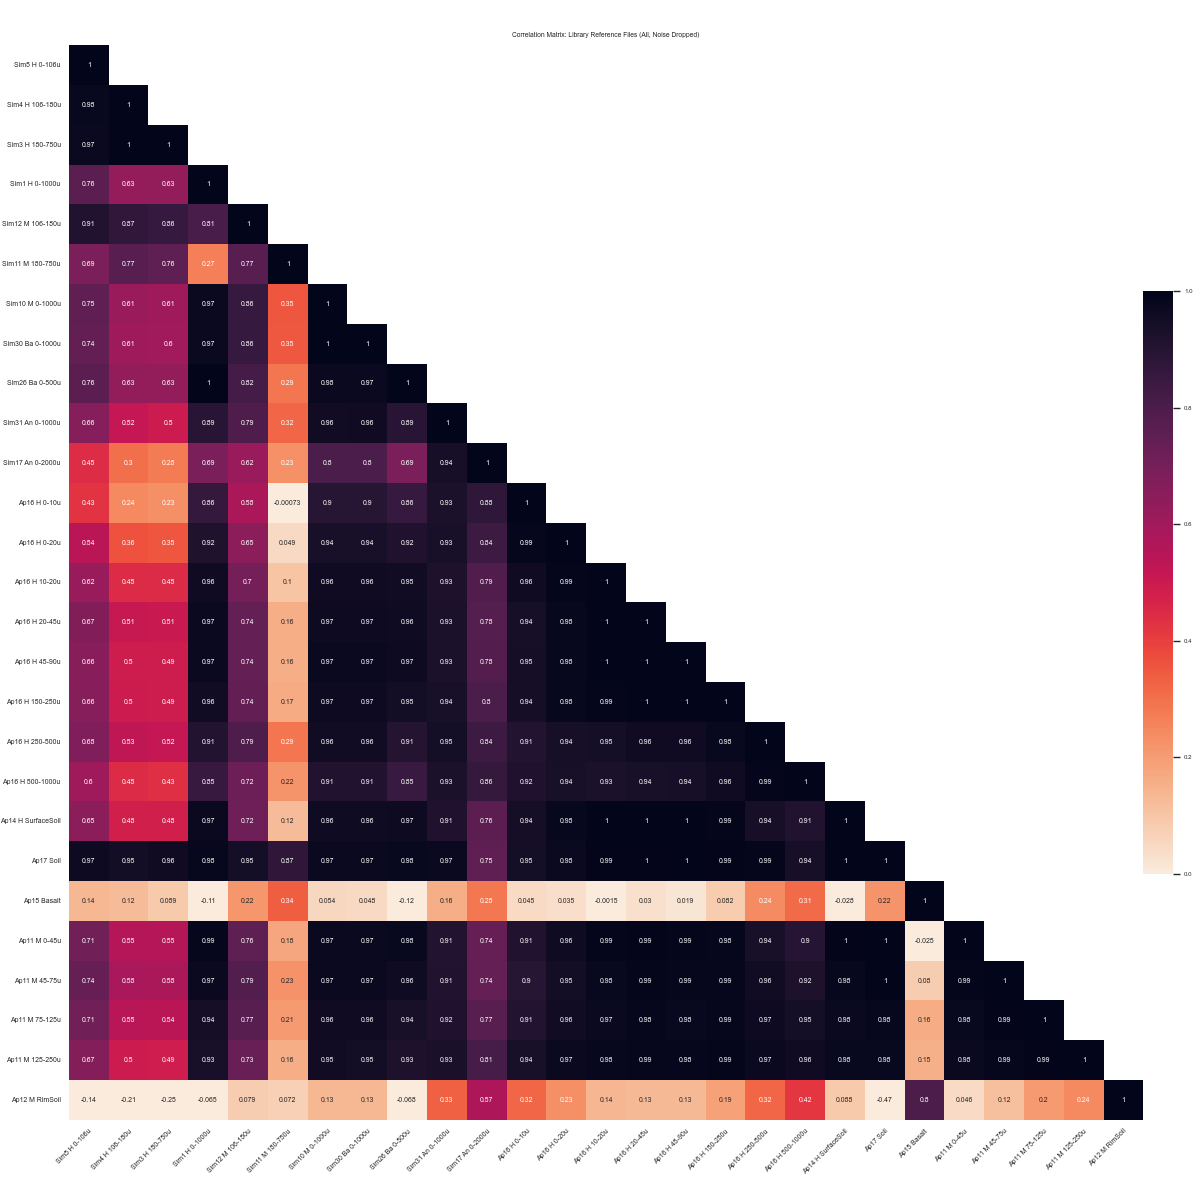

                    Sim5 H 0-106u  Sim4 H 106-180u  Sim3 H 180-750u  \
Sim5 H 0-106u            1.000000         0.977421         0.973445   
Sim4 H 106-180u          0.977421         1.000000         0.997458   
Sim3 H 180-750u          0.973445         0.997458         1.000000   
Sim1 H 0-1000u           0.762714         0.628296         0.630300   
Sim12 M 106-180u         0.913471         0.868607         0.857232   
Sim11 M 180-750u         0.689137         0.772935         0.756839   
Sim10 M 0-1000u          0.750862         0.613956         0.605352   
Sim30 Ba 0-1000u         0.744897         0.607437         0.598680   
Sim26 Ba 0-500u          0.761278         0.630721         0.632492   
Sim31 An 0-1000u         0.661307         0.518626         0.499749   
Sim17 An 0-2000u         0.445045         0.304557         0.275260   
Ap16 H 0-10u             0.427872         0.242479         0.232930   
Ap16 H 0-20u             0.540099         0.359743         0.354018   
Ap16 H

In [15]:
## Step 13

## correlation visualization for all lib files only - Drop version (libcorr_drop)
plt.close('all')

sn.set_theme(style='white')
sn.set_context('paper', font_scale=0.5) # paper,notebook,talk,poster

mask_lib = np.triu(np.ones_like(libcorr_drop, dtype=bool),1) # Generate a mask for the upper triangle (where those cells = True)
f_lib, ax_lib = plt.subplots(figsize=(12,12)) # creates matplotlib figure
ax_lib = sn.heatmap(libcorr_drop, vmin=0, vmax=1, square=True, 
                annot=True, annot_kws={'size':5}, mask=mask_lib,cmap='rocket_r', 
                cbar_kws={'fraction':0.05,'shrink':0.5,'pad':0}) 
# annotated w/ coeffs, masks upper triangle, sets color floor at 0, keeps cells square, shrinks colorbar

title = 'Correlation Matrix: Library Reference Files (All, Noise Dropped)'
ax_lib.set_title(title)
ax_lib.tick_params(axis='both',pad=1,labelsize=5)
plt.setp(ax_lib.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.
f_lib.tight_layout(pad=0) # handles margins
plt.show()

print(libcorr_drop)

## Save plot to file
f_lib.savefig('libraryMx_Drop.pdf')

## Correlation Matrix: Field Data + Library Files

### Create corr matrix w/ NaN replaced Noise bands
Already Shortened: *df_all_nan*, *corrMx_nan*

In [16]:
## Step 14

## create correlation matrix - FIELD vs LIBRARY - All - NaN Replaced (df_chop, df_ref_nan)
df_all_nan = pd.concat([df_chop,df_ref_nan],axis=1)
corrMx_nan = df_all_nan.corr() #.corr(method='pearson')#,'kendall','spearman')
print('All data: ',len(df_all_nan),'\n\n',df_all_nan,'\n\n')
print('Correlation Matrix: ',len(corrMx_nan),'\n\n',corrMx_nan)
df_all_nan.info()
corrMx_nan.info()

All data:  2151 

             PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Wavelength                                                             
350.0       0.016146      0.018525        0.016985          0.021962   
351.0       0.016002      0.018455        0.017070          0.022015   
352.0       0.015951      0.018537        0.016873          0.022002   
353.0       0.016247      0.018499        0.016856          0.022066   
354.0       0.016270      0.018533        0.016990          0.022107   
...              ...           ...             ...               ...   
2496.0           NaN           NaN             NaN               NaN   
2497.0           NaN           NaN             NaN               NaN   
2498.0           NaN           NaN             NaN               NaN   
2499.0           NaN           NaN             NaN               NaN   
2500.0           NaN           NaN             NaN               NaN   

            PS 02 Bottom, Dark  PS 04 PyroxR

### Create corr matrix w/ Dropped Noise bands
Already Shortened: *df_all_drop*, *corrMx_drop*

In [17]:
## Step 15

## create correlation matrix - FIELD vs LIBRARY - All - Dropped (df_drop, df_ref_drop)
df_all_drop = pd.concat([df_drop,df_ref_drop],axis=1)
corrMx_drop = df_all_drop.corr() #.corr(method='pearson')#,'kendall','spearman')
print('All data: ',len(df_all_drop),'\n\n',df_all_drop,'\n\n')
print('Correlation Matrix: ',len(corrMx_drop),'\n\n',corrMx_drop)
df_all_drop.info()
corrMx_drop.info()

All data:  1768 

             PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Wavelength                                                             
350.0       0.016146      0.018525        0.016985          0.021962   
351.0       0.016002      0.018455        0.017070          0.022015   
352.0       0.015951      0.018537        0.016873          0.022002   
353.0       0.016247      0.018499        0.016856          0.022066   
354.0       0.016270      0.018533        0.016990          0.022107   
...              ...           ...             ...               ...   
2395.0      0.031116      0.036382        0.050429          0.102709   
2396.0      0.030350      0.034458        0.050828          0.102907   
2397.0      0.030271      0.032565        0.050748          0.102744   
2398.0      0.029210      0.033138        0.050671          0.102302   
2399.0      0.027229      0.032862        0.050034          0.102100   

            PS 02 Bottom, Dark  PS 04 PyroxR

## Crop Correlation Matrices to Analog vs. Library Rectangle ONLY
Already Shortened: *corrMx_sub*, *corrMx_nan_sub*, *corrMx_drop_sub*

In [18]:
## Step 16

field_length = len(df_drop.columns) # 65

## Try: cutting out the field vs lib rectangle ONLY = rows [#:], cols [:#]

corrMx_sub = corrMx.copy()
corrMx_sub = corrMx_sub.iloc[field_length:,:field_length]

corrMx_nan_sub = corrMx_nan.copy()
corrMx_nan_sub = corrMx_nan_sub.iloc[field_length:,:field_length]

corrMx_drop_sub = corrMx_drop.copy()
corrMx_drop_sub = corrMx_drop_sub.iloc[field_length:,:field_length]

corrMx_drop.shape
corrMx_drop.shape
corrMx_drop_sub.shape

corrMx_drop.info()
corrMx_drop_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, PS Setup to Ap12 M RimSoil
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 92 non-null     float64
 1   PS 01 Basalt             92 non-null     float64
 2   PS 02 Top Soil           92 non-null     float64
 3   PS 02 Mid, Light         92 non-null     float64
 4   PS 02 Bottom, Dark       92 non-null     float64
 5   PS 04 PyroxRock          92 non-null     float64
 6   Spiral 02_AM             92 non-null     float64
 7   Spiral 03_AM             92 non-null     float64
 8   Spiral 04_AM             92 non-null     float64
 9   Spiral 05_AM             92 non-null     float64
 10  Spiral 06_AM             92 non-null     float64
 11  Spiral 07_AM             92 non-null     float64
 12  Spiral 08_AM             92 non-null     float64
 13  Spiral 09_AM             92 non-null     float64
 14  Spiral 10_AM  

# Visualization: Heatmaps for correlation rectangle

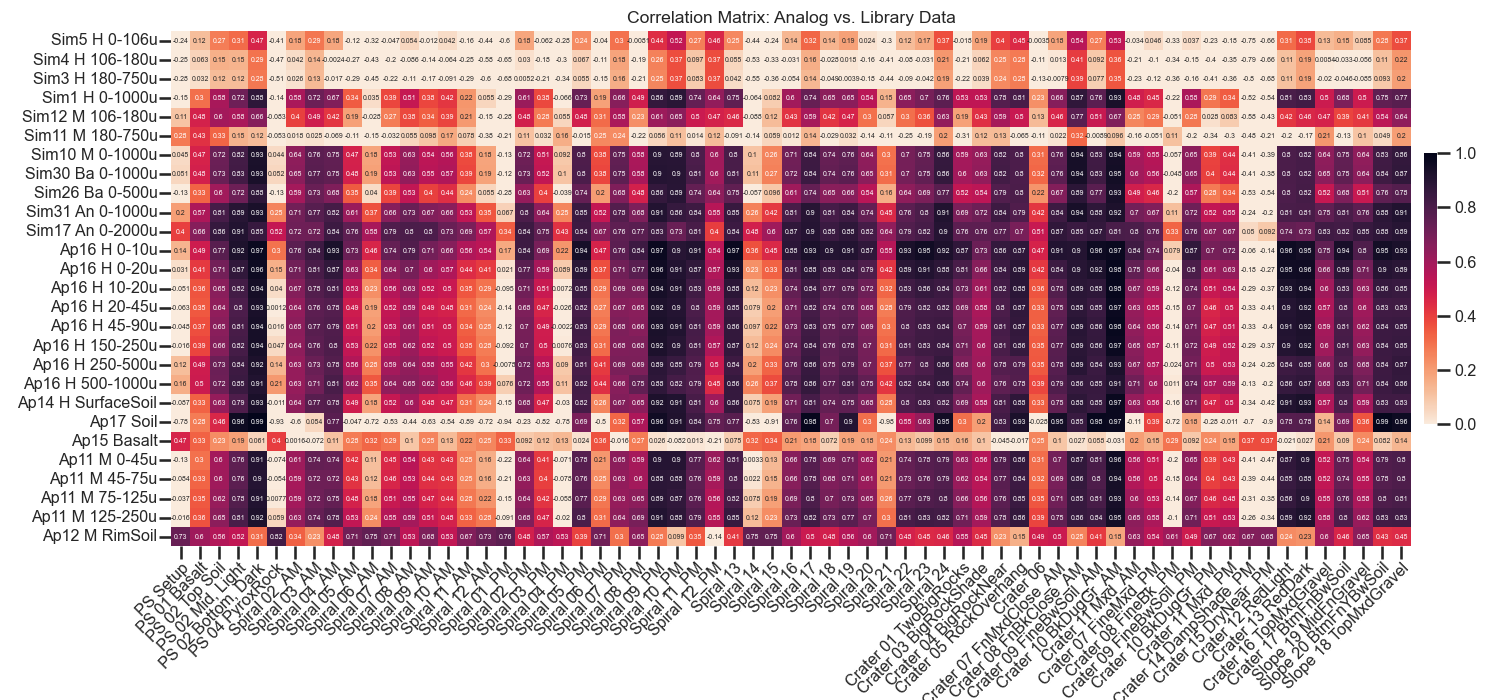

                    PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Sim5 H 0-106u      -0.236740      0.119968        0.270750          0.310124   
Sim4 H 106-180u    -0.247562      0.062822        0.154093          0.147240   
Sim3 H 180-750u    -0.278886      0.032098        0.124519          0.123458   
Sim1 H 0-1000u     -0.150829      0.303318        0.582661          0.716186   
Sim12 M 106-180u    0.105306      0.476112        0.597244          0.581785   
Sim11 M 180-750u    0.280694      0.432132        0.326530          0.146614   
Sim10 M 0-1000u     0.045335      0.472372        0.724324          0.822052   
Sim30 Ba 0-1000u    0.050871      0.476844        0.730132          0.826917   
Sim26 Ba 0-500u    -0.134844      0.325051        0.598724          0.721716   
Sim31 An 0-1000u    0.197927      0.572783        0.814464          0.894533   
Sim17 An 0-2000u    0.400653      0.662797        0.857490          0.908822   
Ap16 H 0-10u        0.140644      0.4929

In [19]:
## Step 17

## correlation visualization for field vs ref rectangle: (corrMx_drop_sub) (made from df_all_drop)
plt.close('all')

sn.set_theme(style='white')
# sn.set_context('paper', font_scale=0.8) # paper,notebook,talk,poster
sn.set_context('talk', font_scale=0.7) # paper,notebook,talk,poster
f_all, ax_all = plt.subplots(figsize=(15,7)) # creates matplotlib figure
ax_all = sn.heatmap(corrMx_drop_sub, vmin=0, vmax=1, square=True,
                    annot=True, annot_kws={'size':5}, cmap='rocket_r',
                    # cbar_kws={'fraction':0.05,'shrink':0.25,'pad':0.05}) 
                    cbar_kws={'location':'right','fraction':0.04,'shrink':0.5,'pad':0.01}) 
# annotated w/ coeffs, sets color floor at 0, keeps cells square, shrinks colorbar

title = 'Correlation Matrix: Analog vs. Library Data'
ax_all.set_title(title)
ax_all.tick_params(axis='both',pad=1)#,labelsize=5)
ax_all.tick_params(left=True,top=False, bottom=True,labeltop=False, labelbottom=True)
plt.setp(ax_all.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.
f_all.tight_layout(pad=1) # handles margins
plt.show()


## Save plot to file
f_all.savefig('allMx_NoNoise_sub.pdf')
## Save plot to file - PNG
# f_all.savefig('allMx_NoNoise_sub.png')

print(corrMx_drop_sub)

# Separate Simulants & Samples

In [20]:
## Step 18

## Create separate lists of Samples and Simulants file names
simu_list = []
samp_list = []

libdir = ['Spectral Library Doc - Sim ONLY.csv','Spectral Library Doc - Samples ONLY.csv'] # split of all original 261: 75 simulants, 186 samples
ctgy = ['Simulants','Samples']

for c, d in enumerate(libdir): # d is a str
    names = []
    names = pd.read_csv(d, names=[ctgy[c]],skiprows=1) # names is a df
    if c == 0:
        simu_list = names[ctgy[c]].values.tolist()
    else:
        samp_list = names[ctgy[c]].values.tolist()
print(len(simu_list),' simulants: ',simu_list,'\n\n',len(samp_list),' samples: ',samp_list)
len(simu_list)+len(samp_list)


75  simulants:  ['bir1je001', 'bir1je002', 'bir1je003', 'bir1je004', 'bir1je005', 'bir1je006', 'bir1je007', 'bir1je008', 'bir1je009', 'bir1je010', 'bir1je011', 'bir1je012', 'bir1je013', 'bir1je014', 'bir1je015', 'bir1je016', 'bir1je017', 'bir1je018', 'bir1je019', 'bir1je020', 'bir1je021', 'bir1je022', 'bir1je023', 'bir1je024', 'bir1je025', 'bir1je026', 'bir1je027', 'bir1je028', 'bir1je029', 'bir1je030', 'bir1je031', 'bir1je032', 'bmr1ba007', 'bmr1dd123b', 'bmr1dh042', 'bmr1pt013', 'c1ba07', 'c1dd123b', 'c1je01', 'c1je02', 'c1je03', 'c1je04', 'c1je05', 'c1je06', 'c1je07', 'c1je08', 'c1je09', 'c1je10', 'c1je11', 'c1je12', 'c1je13', 'c1je14', 'c1je15', 'c1je16', 'c1je17', 'c1je18', 'c1je19', 'c1je20', 'c1je21', 'c1je22', 'c1je23', 'c1je25', 'c1je26', 'c1je27', 'c1je28', 'c1je29', 'c1je30', 'c1je31', 'c1je32', 'c1kc42a', 'c1kc43a', 'c1lw06', 'c1nv17', 'c1nv35', 'c1nv36'] 

 186  samples:  ['bir1lr230', 'bir1lr231', 'bir1lr232', 'bir1lr233', 'bir1lr234', 'bnr1dh031', 'bnr1dh032', 'bnr1dh033

261

In [21]:
## Step 19
simu_select = []
samp_select = []
# for idx, val in filenameslist[1]:
#     if l in simu_list:
#         simu_select.append(l)
#     elif l in samp_list:
#         samp_select.append(l)

        
for idx, val in np.ndenumerate(filenameslist[1]): # go through library selection order
    if val in simu_list:
        i=idx[0]
        label = labelnameslist[1][i]
        simu_select.append(label)
    elif val in samp_list:
        i=idx[0]
        label = labelnameslist[1][i]
        samp_select.append(label)
                
                
print(len(simu_select),' simulants: ',simu_select,'\n\n',len(samp_select),' samples: ',samp_select)
len(simu_select)+len(samp_select)

11  simulants:  ['Sim5 H 0-106u', 'Sim4 H 106-180u', 'Sim3 H 180-750u', 'Sim1 H 0-1000u', 'Sim12 M 106-180u', 'Sim11 M 180-750u', 'Sim10 M 0-1000u', 'Sim30 Ba 0-1000u', 'Sim26 Ba 0-500u', 'Sim31 An 0-1000u', 'Sim17 An 0-2000u'] 

 16  samples:  ['Ap16 H 0-10u', 'Ap16 H 0-20u', 'Ap16 H 10-20u', 'Ap16 H 20-45u', 'Ap16 H 45-90u', 'Ap16 H 150-250u', 'Ap16 H 250-500u', 'Ap16 H 500-1000u', 'Ap14 H SurfaceSoil', 'Ap17 Soil', 'Ap15 Basalt', 'Ap11 M 0-45u', 'Ap11 M 45-75u', 'Ap11 M 75-125u', 'Ap11 M 125-250u', 'Ap12 M RimSoil']


27

In [22]:
## Step 20 - use (simu_select & samp_select)

## group Ref data by simu vs samp

## separate name lists: simu_list (11) & samp_list 16)
## data in df_all_drop & corrMx_drop_sub (rectangle)

corrMx_simu = pd.DataFrame(columns=corrMx_drop_sub.columns) # df: corr data (w/ field data) subset, set col names
corrMx_samp = pd.DataFrame(columns=corrMx_drop_sub.columns)

rows = corrMx_drop_sub.index # returns type index str (index/row/reffile names)
# print(rows)
# print(simu_select)
# print(samp_select)
for r in rows: # str filename, iterates 27 times
    temp = pd.DataFrame(columns=corrMx_drop_sub.columns)
    temp.loc[r] = corrMx_drop_sub.loc[r]
    if r in simu_select: # file is a simulant
        corrMx_simu = pd.concat([corrMx_simu, temp], axis=0) 
    elif r in samp_select: # file is a sample
        corrMx_samp = pd.concat([corrMx_samp, temp], axis=0)

corrMx_simu.info() # 11 entries, 65 columns
corrMx_samp.info() # 16 entries, 65 columns
corrMx_simu
corrMx_samp

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, Sim5 H 0-106u to Sim17 An 0-2000u
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 11 non-null     float64
 1   PS 01 Basalt             11 non-null     float64
 2   PS 02 Top Soil           11 non-null     float64
 3   PS 02 Mid, Light         11 non-null     float64
 4   PS 02 Bottom, Dark       11 non-null     float64
 5   PS 04 PyroxRock          11 non-null     float64
 6   Spiral 02_AM             11 non-null     float64
 7   Spiral 03_AM             11 non-null     float64
 8   Spiral 04_AM             11 non-null     float64
 9   Spiral 05_AM             11 non-null     float64
 10  Spiral 06_AM             11 non-null     float64
 11  Spiral 07_AM             11 non-null     float64
 12  Spiral 08_AM             11 non-null     float64
 13  Spiral 09_AM             11 non-null     float64
 14  Spiral 

PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Ap16 H 0-10u        0.140644      0.492962        0.772735          0.920429   
Ap16 H 0-20u        0.031274      0.413330        0.705333          0.869387   
Ap16 H 10-20u      -0.050526      0.358958        0.654252          0.820338   
Ap16 H 20-45u      -0.063038      0.351155        0.638053          0.798799   
Ap16 H 45-90u      -0.048337      0.368528        0.653963          0.809882   
Ap16 H 150-250u    -0.015703      0.386852        0.664706          0.818480   
Ap16 H 250-500u     0.119329      0.493263        0.725045          0.837678   
Ap16 H 500-1000u    0.159849      0.496356        0.722559          0.845280   
Ap14 H SurfaceSoil -0.086629      0.331653        0.627709          0.794256   
Ap17 Soil          -0.779142      0.276020        0.459792          0.962883   
Ap15 Basalt         0.468184      0.329242        0.234495          0.191995   
Ap11 M 0-45u       -0.129757      0.299179        0.595602          0.757331   
Ap11 M 45-75u      -0.084334      0.325852        0.604442          0.759175   
Ap11 M 75-125u     -0.036703      0.348991        0.622852          0.781397   
Ap11 M 125-250u    -0.016162      0.362074        0.645340          0.808103   
Ap12 M RimSoil      0.733977      0.604060        0.562384          0.524550   

                    PS 02 Bottom, Dark  PS 04 PyroxRock  Spiral 02_AM  \
Ap16 H 0-10u                  0.969401         0.295866      0.764084   
Ap16 H 0-20u                  0.961083         0.154702      0.709465   
Ap16 H 10-20u                 0.943375         0.040248      0.666665   
Ap16 H 20-45u                 0.930566         0.001209      0.636666   
Ap16 H 45-90u                 0.938349         0.016251      0.648350   
Ap16 H 150-250u               0.937813         0.047429      0.644086   
Ap16 H 250-500u               0.922680         0.138230      0.625972   
Ap16 H 500-1000u              0.910487         0.209699      0.626873   
Ap14 H SurfaceSoil            0.931396        -0.011479      0.643369   
Ap17 Soil                     0.994094        -0.930002     -0.597944   
Ap15 Basalt                   0.061102         0.403671      0.001600   
Ap11 M 0-45u                  0.906568        -0.074379      0.611137   
Ap11 M 45-75u                 0.901456        -0.053818      0.586604   
Ap11 M 75-125u                0.906934         0.007671      0.594461   
Ap11 M 125-250u               0.919761         0.058580      0.626068   
Ap12 M RimSoil                0.308455         0.824543      0.335108   

                    Spiral 03_AM  Spiral 04_AM  Spiral 05_AM  ...  \
Ap16 H 0-10u            0.839170      0.926327      0.727477  ...   
Ap16 H 0-20u            0.809278      0.869497      0.625540  ...   
Ap16 H 10-20u           0.784380      0.813885      0.533645  ...   
Ap16 H 20-45u           0.759675      0.780865      0.493838  ...   
Ap16 H 45-90u           0.771909      0.791952      0.507196  ...   
Ap16 H 150-250u         0.761640      0.795759      0.526258  ...   
Ap16 H 250-500u         0.728574      0.782048      0.559463  ...   
Ap16 H 500-1000u        0.713474      0.805541      0.617183  ...   
Ap14 H SurfaceSoil      0.771574      0.783546      0.489328  ...   
Ap17 Soil               0.053805      0.768508     -0.047399  ...   
Ap15 Basalt            -0.071992      0.107334      0.275024  ...   
Ap11 M 0-45u            0.743731      0.735546      0.422444  ...   
Ap11 M 45-75u           0.720412      0.721251      0.427283  ...   
Ap11 M 75-125u          0.717849      0.745311      0.475878  ...   
Ap11 M 125-250u         0.740197      0.783241      0.525060  ...   
Ap12 M RimSoil          0.228863      0.475724      0.708345  ...   

                    Crater 11 Mxd_PM  Crater 14 DampShade_PM  \
Ap16 H 0-10u                0.721051               -0.060485   
Ap16 H 0-20u                0.629770               -0.179491   
Ap16 H 10-20u               0.541510               

## Max Corr for sites

In [23]:
## Step 21
## pull out Highest Match for each ref file/site:

maxcorrs = corrMx_simu.max(axis=1)
maxcols = corrMx_simu.idxmax(axis=1)
maxcorr_simu = pd.DataFrame({'AnalogueSite':maxcols,'CorrCoeff':maxcorrs},index=corrMx_simu.index)
maxcorr_simu

AnalogueSite  CorrCoeff
Sim5 H 0-106u     Crater 08 FnBkClose_AM   0.544818
Sim4 H 106-180u   Crater 08 FnBkClose_AM   0.406327
Sim3 H 180-750u   Crater 08 FnBkClose_AM   0.391106
Sim1 H 0-1000u      Crater 10 BkDugGr_AM   0.932963
Sim12 M 106-180u  Crater 08 FnBkClose_AM   0.767879
Sim11 M 180-750u            PS 01 Basalt   0.432132
Sim10 M 0-1000u     Crater 10 BkDugGr_AM   0.944557
Sim30 Ba 0-1000u    Crater 10 BkDugGr_AM   0.945685
Sim26 Ba 0-500u     Crater 10 BkDugGr_AM   0.934022
Sim31 An 0-1000u  Crater 08 FnBkClose_AM   0.937364
Sim17 An 0-2000u        PS 02 Mid, Light   0.908822

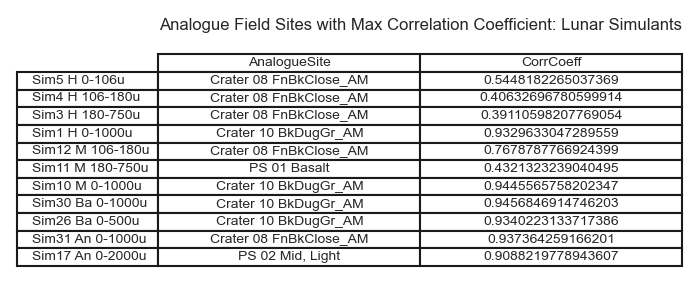

In [24]:
## Step 22
## make table

plt.close('all')

f_t1, ax_t1 = plt.subplots(figsize=(7,3))
ax_t1.axis('off')
ax_t1.axis('tight')
t1 = ax_t1.table(cellText=maxcorr_simu.values, rowLabels=maxcorr_simu.index,colLabels=maxcorr_simu.columns, 
                 cellLoc='center',loc='center')
t1.set_fontsize(10)
title = 'Analogue Field Sites with Max Correlation Coefficient: Lunar Simulants'
ax_t1.set_title(title, fontdict={'fontsize':12})
f_t1.tight_layout(pad=1) # handles margins
plt.show()


## Save plot to file
f_t1.savefig('maxcorrtable_simulants.pdf')

In [25]:
## Step 23
## pull out Highest Match for each ref file/site:

maxcorrs = corrMx_samp.max(axis=1)
maxcols = corrMx_samp.idxmax(axis=1)
maxcorr_samp = pd.DataFrame({'AnalogueSite':maxcols,'CorrCoeff':maxcorrs},index=corrMx_samp.index)
maxcorr_samp

AnalogueSite  CorrCoeff
Ap16 H 0-10u        Crater 10 BkDugGr_AM   0.974450
Ap16 H 0-20u        Crater 10 BkDugGr_AM   0.984300
Ap16 H 10-20u       Crater 10 BkDugGr_AM   0.981943
Ap16 H 20-45u       Crater 10 BkDugGr_AM   0.971050
Ap16 H 45-90u       Crater 10 BkDugGr_AM   0.976881
Ap16 H 150-250u     Crater 10 BkDugGr_AM   0.968968
Ap16 H 250-500u     Crater 10 BkDugGr_AM   0.928495
Ap16 H 500-1000u      PS 02 Bottom, Dark   0.910487
Ap14 H SurfaceSoil  Crater 10 BkDugGr_AM   0.974821
Ap17 Soil             PS 02 Bottom, Dark   0.994094
Ap15 Basalt                     PS Setup   0.468184
Ap11 M 0-45u        Crater 10 BkDugGr_AM   0.956828
Ap11 M 45-75u       Crater 10 BkDugGr_AM   0.939076
Ap11 M 75-125u      Crater 10 BkDugGr_AM   0.933952
Ap11 M 125-250u     Crater 10 BkDugGr_AM   0.946660
Ap12 M RimSoil           PS 04 PyroxRock   0.824543

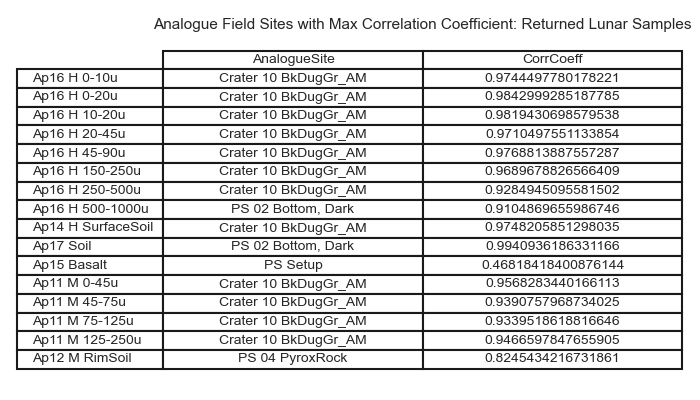

In [26]:
## Step 24
## make table

plt.close('all')

f_t2, ax_t2 = plt.subplots(figsize=(7,4))
ax_t2.axis('off')
ax_t2.axis('tight')
t2 = ax_t2.table(cellText=maxcorr_samp.values, rowLabels=maxcorr_samp.index,colLabels=maxcorr_samp.columns, 
                 cellLoc='center',loc='center')
t2.set_fontsize(10)
title = 'Analogue Field Sites with Max Correlation Coefficient: Returned Lunar Samples'
ax_t2.set_title(title, fontdict={'fontsize':11})
f_t2.tight_layout(pad=1) # handles margins
plt.show()


## Save plot to file
f_t2.savefig('maxcorrtable_samples.pdf')


# Visualization: Heatmaps for correlation for field vs ref rectangle

## SIMULANTS ONLY 
*(corrMx_simu)*

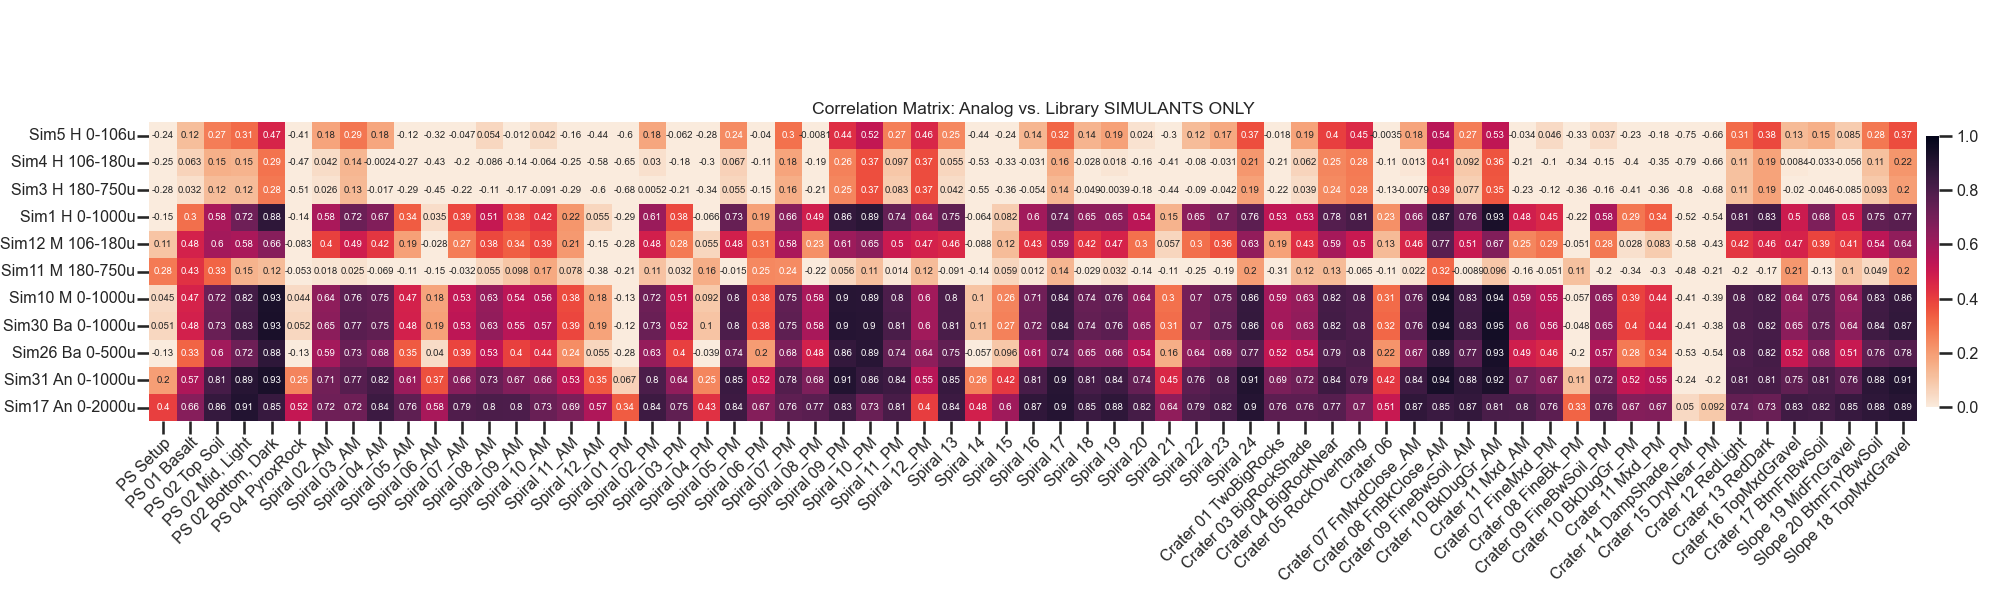

                  PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Sim5 H 0-106u    -0.236740      0.119968        0.270750          0.310124   
Sim4 H 106-180u  -0.247562      0.062822        0.154093          0.147240   
Sim3 H 180-750u  -0.278886      0.032098        0.124519          0.123458   
Sim1 H 0-1000u   -0.150829      0.303318        0.582661          0.716186   
Sim12 M 106-180u  0.105306      0.476112        0.597244          0.581785   
Sim11 M 180-750u  0.280694      0.432132        0.326530          0.146614   
Sim10 M 0-1000u   0.045335      0.472372        0.724324          0.822052   
Sim30 Ba 0-1000u  0.050871      0.476844        0.730132          0.826917   
Sim26 Ba 0-500u  -0.134844      0.325051        0.598724          0.721716   
Sim31 An 0-1000u  0.197927      0.572783        0.814464          0.894533   
Sim17 An 0-2000u  0.400653      0.662797        0.857490          0.908822   

                  PS 02 Bottom, Dark  PS 04 PyroxRock  Spiral 0

In [27]:
## Step 25
## correlation visualization for field vs ref rectangle - SIMULANTS ONLY (corrMx_simu)
# simu_corrMx = corrMx_simu.T
simu_corrMx = corrMx_simu

plt.close('all')

sn.set_theme(style='white')
# sn.set_context('paper', font_scale=1) # paper,notebook,talk,poster
sn.set_context('talk', font_scale=0.7)
f_sim, ax_sim = plt.subplots(figsize=(20,6)) # creates matplotlib figure
ax_sim = sn.heatmap(simu_corrMx, vmin=0, vmax=1, square=True,
                    annot=True, annot_kws={'size':7}, cmap='rocket_r',
                    # cbar_kws={'fraction':0.05,'shrink':0.25,'pad':0.05}) 
                    cbar_kws={'location':'right','fraction':0.04,'shrink':0.5,'pad':0.005}) 
# annotated w/ coeffs, sets color floor at 0, keeps cells square, shrinks colorbar

title = 'Correlation Matrix: Analog vs. Library SIMULANTS ONLY'
ax_sim.set_title(title)
ax_sim.tick_params(axis='both',pad=1)#,labelsize=7)
ax_sim.tick_params(left=True,top=False, bottom=True,labeltop=False, labelbottom=True)
plt.setp(ax_sim.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.
f_sim.tight_layout(pad=0.01) # handles margins
plt.show()

## Save plot to file
f_sim.savefig('corrMx_simulants.pdf')
## Save plot to file - PNG
f_sim.savefig('corrMx_simulants.png')

print(simu_corrMx)


## SAMPLES ONLY 
*(corrMx_samp)*

In [ ]:
## Step 26
## correlation visualization for field vs ref rectangle - SAMPLES ONLY (corrMx_samp)
# samp_corrMx = corrMx_samp.T
samp_corrMx = corrMx_samp

plt.close('all')

sn.set_theme(style='white')
# sn.set_context('paper', font_scale=1) # paper,notebook,talk,poster
sn.set_context('talk', font_scale=0.7)

f_samp, ax_samp = plt.subplots(figsize=(20,7)) # creates matplotlib figure
ax_samp = sn.heatmap(samp_corrMx, vmin=0, vmax=1, square=True,
                    annot=True, annot_kws={'size':7}, cmap='rocket_r',
                    # cbar_kws={'fraction':0.05,'shrink':0.25,'pad':0.05}) 
                    cbar_kws={'location':'right','fraction':0.04,'shrink':0.5,'pad':0.005}) 
# annotated w/ coeffs, sets color floor at 0, keeps cells square, shrinks colorbar

title = 'Correlation Matrix: Analog vs. Library SAMPLES ONLY'
ax_samp.set_title(title)
ax_samp.tick_params(axis='both',pad=1)#,labelsize=6)
ax_samp.tick_params(left=True,top=False, bottom=True,labeltop=False, labelbottom=True)
plt.setp(ax_samp.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.
f_samp.tight_layout(pad=1) # handles margins
plt.show()

## Save plot to file
f_samp.savefig('corrMx_samples.pdf')
## Save plot to file - PNG
f_samp.savefig('corrMx_samples.png')

print(samp_corrMx)


# Distance Section